In [277]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import jaccard_score, confusion_matrix, classification_report, f1_score, accuracy_score

In [278]:
df_train = pd.read_csv('train_new.csv', index_col=0)
df_test = pd.read_csv('test_new.csv', index_col=0)

In [279]:
df_train.shape

(233154, 33)

<br>

Due to the size of the data and the lack of computing power on my machine I will take a random sample of 10000 records of this dataset.


This will help reduce the processing time when using models like SVM or KNN.

In [280]:
train = df_train.sample(10000)

<br>
<br>
Let's compare the distribution of LOAN_DEFAULT values in the original vs the random sample dataset

In [281]:
print(f'Random set: \n {train.LOAN_DEFAULT.value_counts(normalize=True)}, \n Original set: \n {df_train.LOAN_DEFAULT.value_counts(normalize=True)}')

Random set: 
 0    0.7859
1    0.2141
Name: LOAN_DEFAULT, dtype: float64, 
 Original set: 
 0    0.782929
1    0.217071
Name: LOAN_DEFAULT, dtype: float64


<br>


#### They are fairly close with a similar distribution in values of LOAN_DEFAULT, so the random set is a true representation of the large, original set.

___

# Preprocessing and normalizing the data

<br>

In this section I will:
+ separate the class variable from the rest of the dataset
+ separate binary values from continuous ones
+ normalize continuous values
+ split the data to train and test set

In [282]:
# Separating the class variables from the rest of the dataset
X = train.drop(['LOAN_DEFAULT'], axis=1)
y = train['LOAN_DEFAULT'].values

In [283]:
binaries = X[['PAN_FLAG','VOTERID_FLAG','AADHAR_FLAG', 'DRIVING_FLAG', 'PASSPORT_FLAG', 'Salaried', 'Self employed']]
continuous = X.drop(binaries, axis=1)

In [284]:
continuous = StandardScaler().fit(continuous).transform(continuous.astype('float'))

In [285]:
X = np.concatenate((binaries.values, continuous), axis=1)
X[:1]

array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  0.        , -1.30511005, -0.95574654, -0.35899798,
        -1.00097019, -1.57353236, -1.08694052, -1.40152748,  0.48471018,
         0.02437024, -0.29175236, -0.02595469,  1.50850072,  0.03585361,
        -0.17962971, -0.17909871, -0.04900669, -0.05309429, -0.05225405,
        -0.06581993, -0.4016582 , -0.26601103,  1.06784098,  0.33395952,
        -0.2898591 , -1.0133066 ]])

<br>

*Although the original data was split to train and test sets, I discovered that the test data had not been labeled, which makes it difficult to measure the accuracy of the models.*

*To resolve, this I will split the train dataset with a 0.3 test size so that I can measure the accuracy.*

*The dataset called 'test' will be used for the actual prediction once the models have been built.*

In [286]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7000, 32) (3000, 32) (7000,) (3000,)


In [287]:
# Factory function for confusion matrices
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')




# 1st model: K-nearest neighbor


___
First, I will find the best value for k

In [288]:
from sklearn.neighbors import KNeighborsClassifier

In [289]:
Ks = np.arange(1,20, 1);
scores = []
for k in Ks:
    knn  = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
    yhat = knn.predict(X_test)
    scores.append(accuracy_score(y_test, yhat))

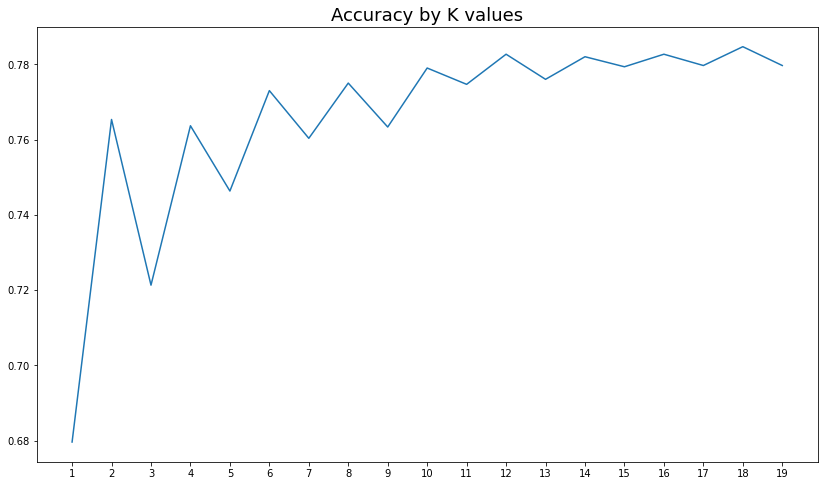

In [290]:
plt.figure(figsize=(14,8))
plt.plot(Ks, scores)
plt.xticks(Ks)
plt.title('Accuracy by K values', size=18)
plt.show()

Based on the chart the k value with the highest accuracy on this dataset is 16.

I will now run the model with this k value and save the predictions

In [247]:
knn  = KNeighborsClassifier(n_neighbors=16).fit(X_train,y_train)
KNNpred = knn.predict(X_test)
KNNpred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [295]:
knn.score(X_train, y_train)

0.7878571428571428

In [248]:
jaccard_KNN = jaccard_score(y_test, KNNpred, average='weighted')
f1_KNN = f1_score(y_test, KNNpred, average='weighted')
accuracy_KNN = accuracy_score(y_test, KNNpred)
print(jaccard_KNN, f1_KNN, accuracy_KNN)

0.6197550220480157 0.6996000000000001 0.7846666666666666


Confusion matrix, without normalization
[[2337   15]
 [ 631   17]]


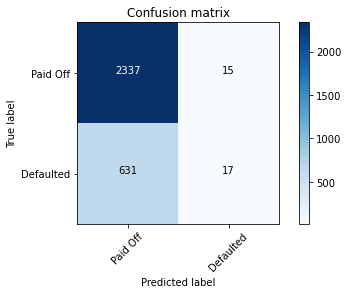

In [249]:
cm = confusion_matrix(y_test, KNNpred, labels=[0,1])
plot_confusion_matrix(cm, classes=['Paid Off','Defaulted'],normalize= False,  title='Confusion matrix')

___

# 2nd model: Support Vector Machine 

<br>

I first try the Radial Basis Function kernel and see its accuracy

In [250]:
from sklearn.svm import SVC

In [251]:
svm = SVC(kernel='rbf').fit(X_train, y_train)

In [252]:
SVMpred = svm.predict(X_test)
SVMpred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [253]:
jaccard_SVM = jaccard_score(y_test, SVMpred, average='weighted')
f1_SVM = f1_score(y_test, SVMpred, average='weighted')
accuracy_SVM = accuracy_score(y_test, SVMpred)
print(jaccard_SVM, f1_SVM, accuracy_SVM)

0.6146704203965425 0.6895400199701394 0.7836666666666666


Confusion matrix, without normalization
[[2350    2]
 [ 647    1]]


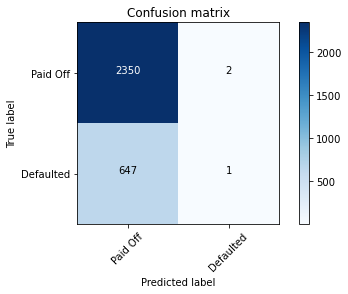

In [254]:
cm = confusion_matrix(y_test, SVMpred, labels=[0,1])
plot_confusion_matrix(cm, classes=['Paid Off','Defaulted'],normalize= False,  title='Confusion matrix')

---
I will now try different kernel functions and see which one produces the best results



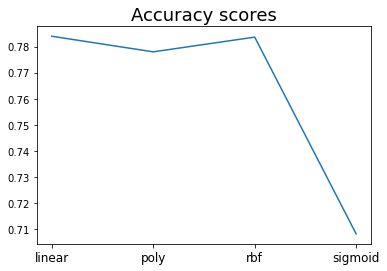

In [255]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
scores = []
for kernel in kernels:
    svm = SVC(kernel=kernel).fit(X_train, y_train)
    yhat = svm.predict(X_test)
    scores.append(accuracy_score(y_test, yhat))
    
plt.plot(kernels, scores)
plt.title('Accuracy scores', size=18)
plt.xticks(size=12)
plt.show()

In [256]:
print(scores)

[0.784, 0.778, 0.7836666666666666, 0.708]


It appears that the Linear kernel produces the highest accuracy, along with the Radial Basis Function function.

I will now re-build the model with Linear kernel.

In [257]:
svm = SVC(kernel='linear').fit(X_train, y_train)

In [294]:
svm.score(X_train,y_train)

0.7854285714285715

In [258]:
SVMpred = svm.predict(X_test)
SVMpred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [259]:
jaccard_SVM = jaccard_score(y_test, SVMpred, average='weighted')
f1_SVM = f1_score(y_test, SVMpred, average='weighted')
accuracy_SVM = accuracy_score(y_test, SVMpred)
print(jaccard_SVM, f1_SVM, accuracy_SVM)

0.614656 0.6890762331838566 0.784


---
# 3rd model: Decision Tree

<br>

Let's first see what's the best value for max_depth

In [260]:
from sklearn.tree import DecisionTreeClassifier

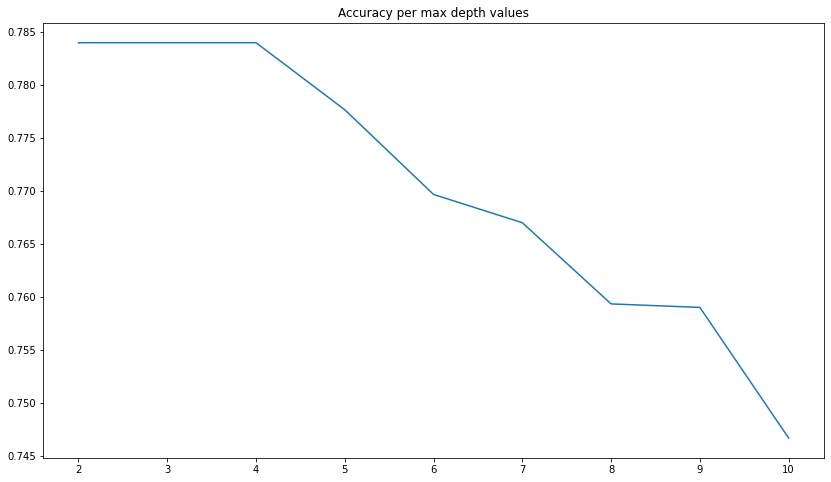

In [261]:
values = range(2,11)
scores = []
for value in values:
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=value).fit(X_train, y_train)
    yhat = tree.predict(X_test)
    scores.append(accuracy_score(y_test, yhat))
plt.figure(figsize=(14,8))
plt.plot(values, scores)
plt.title('Accuracy per max depth values')
plt.show()

A value of 2 seems to produce the best result

In [262]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=4).fit(X_train, y_train)

In [293]:
tree.score(X_train,y_train)

0.7854285714285715

In [263]:
TREEpred = tree.predict(X_test)

In [264]:
accuracy_TREE = accuracy_score(y_test, TREEpred)
jaccard_TREE = jaccard_score(y_test, TREEpred, average='weighted')
f1_TREE = f1_score(y_test, TREEpred, average='weighted')

Confusion matrix, without normalization
[[2352    0]
 [ 648    0]]


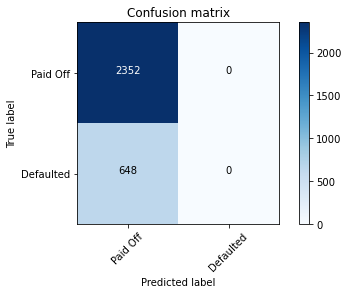

In [265]:
cm = confusion_matrix(y_test, TREEpred, labels=[0,1])
plot_confusion_matrix(cm, classes=['Paid Off','Defaulted'],normalize= False,  title='Confusion matrix')

---


# 4th model: Logistic Regression


<br>


I will use the liblinear solver with a regularization value of 0.01

In [266]:
from sklearn.linear_model import LogisticRegression

In [267]:
lr = LogisticRegression(C=0.01, solver='liblinear').fit(X_train, y_train.astype('int'))

In [268]:
LRpred = lr.predict(X_test)
LRpred[:5]

array([0, 0, 0, 0, 0])

In [269]:
accuracy_LR = accuracy_score(y_test, LRpred)
jaccard_LR = jaccard_score(y_test, LRpred, average='weighted')
f1_LR = f1_score(y_test, LRpred, average='weighted')

In [271]:
print(classification_report(y_test, LRpred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      2352
           1       0.38      0.00      0.01       648

    accuracy                           0.78      3000
   macro avg       0.58      0.50      0.44      3000
weighted avg       0.70      0.78      0.69      3000



Confusion matrix, without normalization
[[2347    5]
 [ 645    3]]


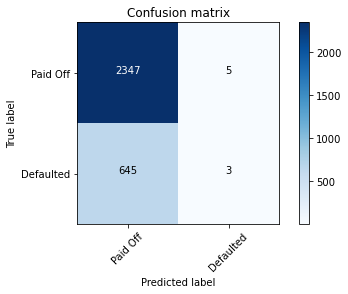

In [272]:
cm = confusion_matrix(y_test, LRpred, labels=[0,1])
plot_confusion_matrix(cm, classes=['Paid Off','Defaulted'],normalize= False,  title='Confusion matrix')

---

# Evaluation of all 4 models

In [273]:
model_scores = {
    'K-nearest neighbours':{'Jaccard index': jaccard_KNN, 'F1 score': f1_KNN, 'Accuracy score': accuracy_KNN},
    'Decision Tree':{'Jaccard index': jaccard_TREE, 'F1 score': f1_TREE, 'Accuracy score': accuracy_TREE},
    'Support Vector Machine':{'Jaccard index': jaccard_SVM, 'F1 score': f1_SVM, 'Accuracy score': accuracy_SVM},
    'Logistic Regression':{'Jaccard index': jaccard_LR, 'F1 score': f1_LR, 'Accuracy score': accuracy_LR}
}

In [274]:
report = pd.DataFrame(model_scores)
report

,K-nearest neighbours,Decision Tree,Support Vector Machine,Logistic Regression
Jaccard index,0.619755,0.614656,0.614656,0.614956
F1 score,0.699600,0.689076,0.689076,0.690616
Accuracy score,0.784667,0.784000,0.784000,0.783333


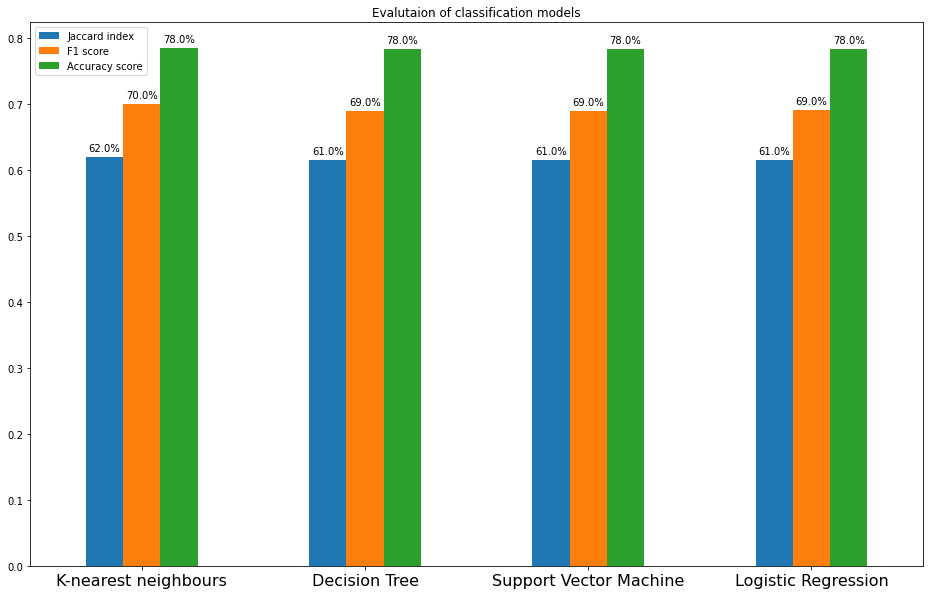

In [275]:
splt = report.T.plot(kind='bar', figsize=(16,10))
for p in splt.patches:
    splt.annotate(format(round(p.get_height(), 2) * 100)+"%",
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 9),
                   textcoords='offset points')
plt.xticks(rotation=0, size=16)
plt.title('Evalutaion of classification models')
plt.show()

# Conclusion

---
None of the models performs well in predicting loan defaults:
+ Decision Tree had zero correct predicition of defaults 
+ K nearest neighbours performed the best with a mere 17 correct predictions out of 631, which is still very low

#### This issue here is the so called Imbalanced Classification problem that results from the skewed distribution of the class variable.
* 78.29% of the data is classified as paid, and only 21.71% is labelled as defaulted

The models are therefore treating the majority class as a default class and mislabels the test set as the minority class is seen as anomaly or abnormal case

<br>

**Solutions to overcome this problem could be:**
+ increasing the size of the dataset
+ resampling with SMOTE
+ resampling with different ratios of the class
